This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goals is to segment cell and extract morphology features from cellprofiler.
These masks must be imported into cellprofiler to extract features.

## import libraries 

In [74]:
import argparse
import itertools
import multiprocessing
import pathlib
import sys
from multiprocessing import Pool

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import pandas as pd
import skimage
import tifffile
import tqdm
from skimage import io

sys.path.append("../../utils")
from segmentation_decoupling import (
    check_coordinate_inside_box,
    euclidian_2D_distance,
    get_larger_bbox,
)

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

## parse args and set paths

In [75]:
if not in_notebook:
    print("Running as script")
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--input_dir",
        type=str,
        help="Path to the input directory containing the tiff images",
    )
    parser.add_argument(
        "--compartment",
        type=str,
        default="none",
        help="Compartment to segment. Options are 'nuclei', 'cell', and 'organoid'",
    )
    parser.add_argument(
        "--window_size",
        type=int,
        default=5,
        help="Window size for the median filter",
    )

    args = parser.parse_args()
    input_dir = pathlib.Path(args.input_dir).resolve(strict=True)
    compartment = args.compartment
    window_size = args.window_size
else:
    print("Running in a notebook")
    input_dir = pathlib.Path("../../data/NF0014/normalized_z/C4-2/").resolve(
        strict=True
    )
    compartment = "organoid"
    window_size = 3

mask_path = pathlib.Path(f"../processed_data/{input_dir.stem}").resolve()
mask_path.mkdir(exist_ok=True, parents=True)

if compartment == "nuclei":
    mask_file_path = pathlib.Path(mask_path / "nuclei_masks.tiff").resolve()
    reconstruction_dict_path = pathlib.Path(
        mask_path / "nuclei_reconstruction_dict.npy"
    ).resolve(strict=True)
    distance_threshold = 20
elif compartment == "cell":
    mask_file_path = pathlib.Path(mask_path / "cell_masks.tiff").resolve()
    reconstruction_dict_path = pathlib.Path(
        mask_path / "cell_reconstruction_dict.npy"
    ).resolve(strict=True)
    distance_threshold = 50
elif compartment == "organoid":
    mask_file_path = pathlib.Path(mask_path / "organoid_masks.tiff").resolve()
    reconstruction_dict_path = pathlib.Path(
        mask_path / "organoid_reconstruction_dict.npy"
    ).resolve(strict=True)
    distance_threshold = 100
else:
    raise ValueError(
        "Invalid compartment, please choose 'nuclei', 'cell', or 'organoid'"
    )

Running in a notebook


## Set up images, paths and functions

In [76]:
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]
# get the nuclei image
for f in files:
    if compartment == "nuclei" and "405" in f:
        imgs = io.imread(f)
    elif compartment == "cell" and "555" in f:
        imgs = io.imread(f)
    elif compartment == "organoid" and "488" in f:
        imgs = io.imread(f)
imgs = np.array(imgs)
original_imgs = imgs.copy()
original_img_shape = imgs.shape
original_z_slice_count = len(imgs)
print("number of z slices in the original image:", original_z_slice_count)

number of z slices in the original image: 33


In [77]:
reconstruction_dict = np.load(reconstruction_dict_path, allow_pickle=True).item()

## Reverse the sliding window max projection

In [86]:
def extract_unique_masks(image_stack):
    mask_indices_dict = {
        "unique_mask": [],
        "mask_indices": [],
        "psuedo_slice": [],
        "y_x_coords": [],
        "bbox": [],
        "merged/lone": [],
    }
    # find each unqiue mask identity via pixel value
    unique_masks = np.unique(image_stack)
    # loop through each unique mask identity
    # drop the backgound as a mask identity
    unique_masks = unique_masks[unique_masks != 0]
    for unique_mask in unique_masks:
        # loop through each mask image
        for psuedo_slice in range(len(image_stack)):
            # find where the unique mask identity is in the mask image
            tmp_image = image_stack[psuedo_slice]
            # get only the unique mask
            image_for_coordinates = np.array(tmp_image == unique_mask, dtype=np.uint8)
            mask_indices = np.where(tmp_image == unique_mask)
            # if the mask identity is in the mask image
            mask_indices_dict["unique_mask"].append(unique_mask)
            mask_indices_dict["mask_indices"].append(mask_indices)
            mask_indices_dict["psuedo_slice"].append(psuedo_slice)
            c = skimage.measure.regionprops(image_for_coordinates)
            for property in c:
                centroid = property.centroid
                bbox = property.bbox
                mask_indices_dict["y_x_coords"].append(centroid)
                mask_indices_dict["bbox"].append(bbox)
            if len(mask_indices_dict["y_x_coords"]) < len(
                mask_indices_dict["mask_indices"]
            ):
                mask_indices_dict["y_x_coords"].append(None)
                mask_indices_dict["bbox"].append(None)
            # check if the mask is merged or lone
            mask_indices_dict["merged/lone"].append(None)

    unique_masks_df = pd.DataFrame(mask_indices_dict)
    return unique_masks_df


def compare_masks_for_merged(df: pd.DataFrame, index1, index2):
    output_dict = {
        "unique_mask": [],
        "mask_indices": [],
        "psuedo_slice": [],
        "y_x_coords": [],
        "bbox": [],
        "merged/lone": [],
        "area": [],
        "index_comparison": [],
    }
    # get the x_y coordinates and bbox of the other index
    current_xy = df["y_x_coords"][index1]
    current_bbox = df["bbox"][index1]
    other_xy = df["y_x_coords"][index2]
    other_bbox = df["bbox"][index2]
    # if the x_y coordinates are not None
    if other_xy is not None and current_xy is not None:
        distance = euclidian_2D_distance(current_xy, other_xy)
        if distance < distance_threshold:
            # check which bounding box has the larger area
            if get_larger_bbox(current_bbox, other_bbox) == current_bbox:
                # check if the x_y coordinates are within the bbox of the other coordinates
                coordinate_inside_box = check_coordinate_inside_box(
                    other_xy, current_bbox
                )
                if coordinate_inside_box:
                    output_dict["unique_mask"].append(index1)
                    output_dict["mask_indices"].append(df["mask_indices"][index1])
            elif get_larger_bbox(current_bbox, other_bbox) == other_bbox:
                coordinate_inside_box = check_coordinate_inside_box(
                    current_xy, other_bbox
                )
                if coordinate_inside_box:
                    output_dict["unique_mask"].append(index2)
                    output_dict["mask_indices"].append(df["mask_indices"][index2])
            else:
                coordinate_inside_box = False
            # check if the x_y coordinates are within the bbox of the other coordinates
            if coordinate_inside_box:
                # add the indices to the output dict
                output_dict["psuedo_slice"].append(df["psuedo_slice"][index1])
                output_dict["y_x_coords"].append(other_xy)
                output_dict["bbox"].append(other_bbox)
                mask_array = df["mask_indices"][index2]

                # get the area of the mask
                mask_array = np.array(mask_array)
                area = mask_array.shape[0] * mask_array.shape[1]
                output_dict["area"].append(area)
                output_dict["index_comparison"].append(f"{index1},{index2}")
                output_dict["merged/lone"].append("merged")
        else:
            output_dict["unique_mask"].append(index1)
            output_dict["mask_indices"].append(df["mask_indices"][index1])
            output_dict["psuedo_slice"].append(df["psuedo_slice"][index1])
            output_dict["y_x_coords"].append(current_xy)
            output_dict["bbox"].append(current_bbox)
            output_dict["area"].append(None)
            output_dict["index_comparison"].append(f"{index1},{index2}")
            output_dict["merged/lone"].append("lone")

    new_df = pd.DataFrame(output_dict)
    return new_df


# get each combination of indices


def get_combinations_of_indices(df):
    original_shape = df.shape[0]
    if original_shape < 2:
        return df
    list_of_dfs = []
    for index1 in range(len(df)):
        for index2 in range(1 + index1, len(df)):
            new_df = compare_masks_for_merged(df, index1, index2)
            list_of_dfs.append(new_df)
    dfs = pd.concat(list_of_dfs).reset_index(drop=True)

    # get only the merged masks
    if not dfs.shape[0] < 2:
        merged_df = dfs[dfs["merged/lone"] == "merged"]
    else:
        merged_df = dfs

    # merged_df[["index1", "index2"]] = merged_df["index_comparison"].str.split(",", expand=True)
    merged_df = merged_df.assign(
        index1=merged_df["index_comparison"].str.split(",", expand=True)[0].astype(int),
        index2=merged_df["index_comparison"].str.split(",", expand=True)[1].astype(int),
    )
    merged_df.reset_index(drop=True, inplace=True)
    return merged_df


# if 0 merges with 1 and 0 merges with 2, then 1 and 2 are merged
def merge_sets(merged_df):
    if merged_df.shape[0] < 2:
        merged_df["label"] = 1
        return merged_df
    index_sets = merged_df["index_comparison"]
    # convert to list of sets
    list_of_sets = [set(map(int, x.split(","))) for x in index_sets]
    for i in list_of_sets:
        for j in list_of_sets:
            if i != j and len(i.intersection(j)) > 0:
                i.update(j)
                list_of_sets.remove(j)
    merged_sets_dict = {}
    for i in range(len(list_of_sets)):
        merged_sets_dict[i] = list_of_sets[i]

    for row in merged_df.iterrows():
        for num_set in merged_sets_dict:
            if int(row[1]["index1"]) in merged_sets_dict[num_set]:
                merged_df.at[row[0], "label"] = num_set
    list_of_dfs = []
    for unique_label in merged_df["label"].unique():
        tmp_df = merged_df[merged_df["label"] == unique_label]
        # keep one row that has the largest area
        largest_area_index = tmp_df["area"].idxmax()
        tmp_df = tmp_df.loc[largest_area_index]
        list_of_dfs.append(tmp_df)
    merged_df = pd.DataFrame(list_of_dfs)

    return merged_df


def reassemble_each_mask(df):
    # get the dimensions of the original image
    # make an empty array to hold the reassembled masks

    dict_of_masks = {}
    # get all unique group indices
    label = np.unique(df["label"])
    for index in label:
        tmp_df = df.loc[df["label"] == index]
        dict_of_masks[index] = tmp_df["mask_indices"].values
    reassembled_masks = np.zeros(
        (original_imgs.shape[1], original_imgs.shape[2]), dtype=np.uint8
    )
    for index, mask in dict_of_masks.items():
        # set the pixels in the reassembled masks to the index value
        for m in mask:
            reassembled_masks[m] = index + 1
    return reassembled_masks


def get_dimensionality(image_array: np.ndarray):
    if not isinstance(image_array, np.ndarray):
        raise TypeError("image_array must be a numpy array")
    return len(image_array.shape)


def get_number_of_unique_labels(image_array: np.ndarray):
    get_dimensionality(image_array)
    return len(np.unique(image_array))

In [87]:
get_dimensionality(np.array([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]]))

3

In [88]:
df = extract_unique_masks(reconstruction_dict[0])
merged_df = get_combinations_of_indices(df)
merged_df = merge_sets(merged_df)
reassembled_masks = reassemble_each_mask(merged_df)
reassembled_masks

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [89]:
masks_dict = {}
for slice, arrays in tqdm.tqdm(enumerate(reconstruction_dict)):
    df = extract_unique_masks(reconstruction_dict[slice])

    merged_df = get_combinations_of_indices(df)
    merged_df = merge_sets(merged_df)
    merged_df.loc[:, "slice"] = slice
    reassembled_masks = reassemble_each_mask(merged_df)
    masks_dict[slice] = reassembled_masks

33it [00:04,  6.65it/s]


In [ ]:
# convert the masks_dict to a numpy array
masks = np.zeros(
    (original_z_slice_count, original_img_shape[1], original_img_shape[2]),
    dtype=np.uint16,
)
masks = np.array(list(masks_dict.values()))
if get_number_of_unique_labels(masks) > 255:
    masks = masks.astype(np.uint16)
else:
    masks = masks.astype(np.uint8)

# save the masks
tifffile.imwrite(mask_file_path, masks)

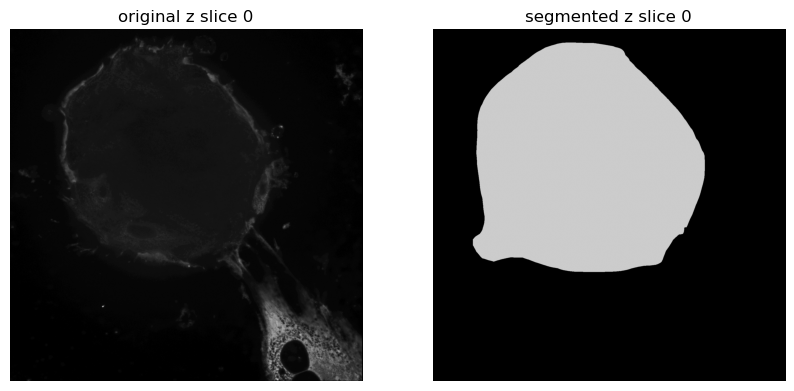

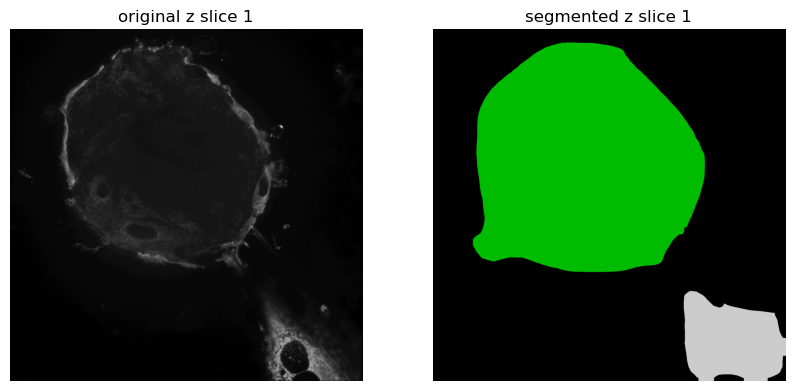

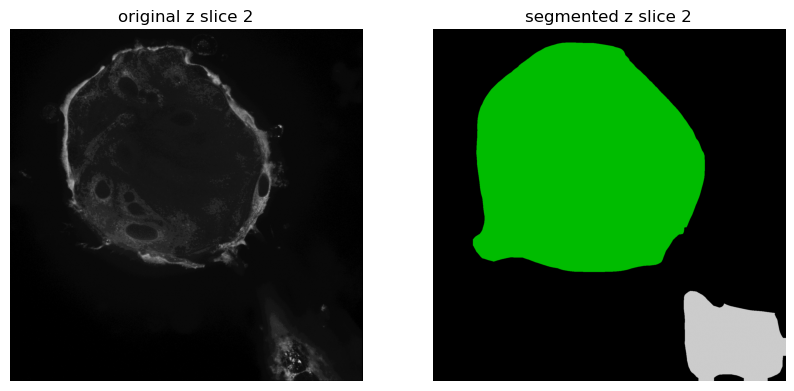

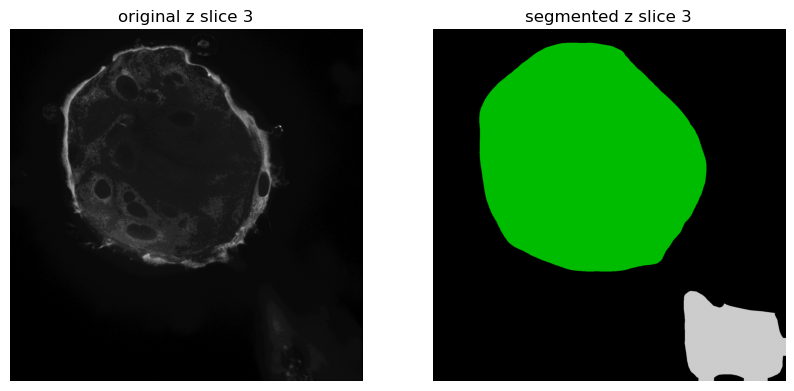

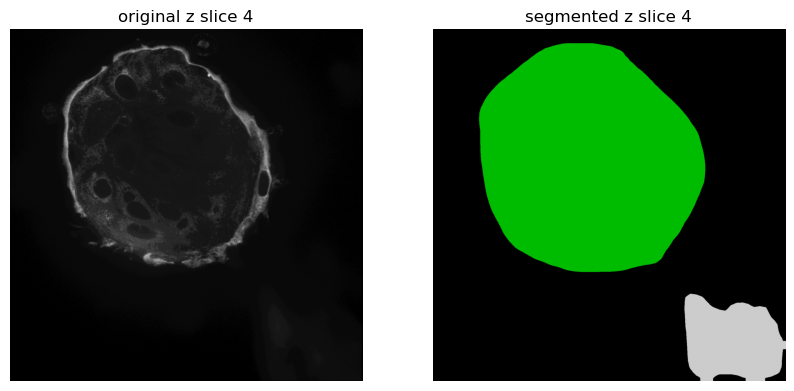

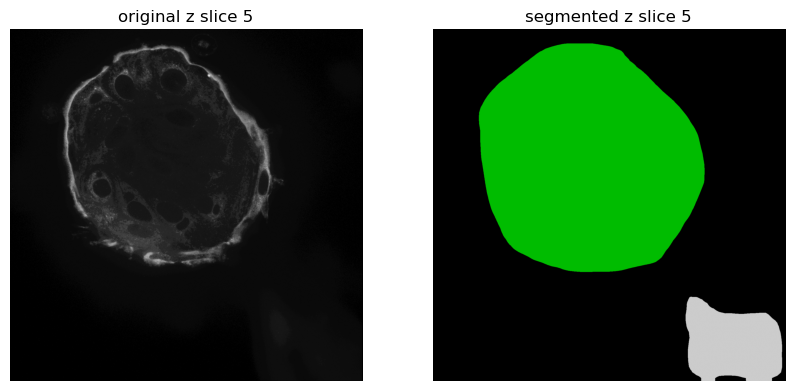

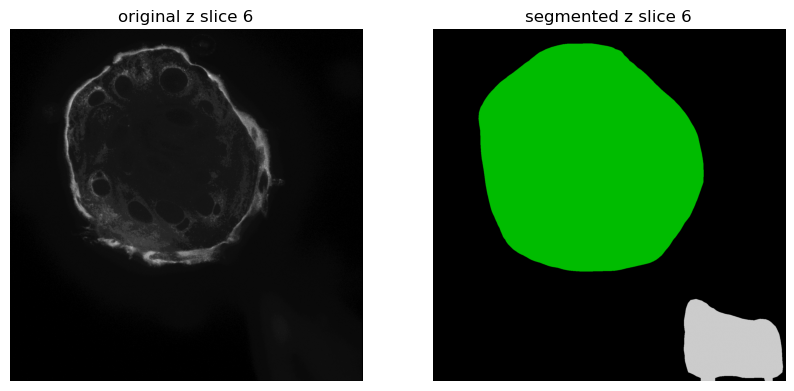

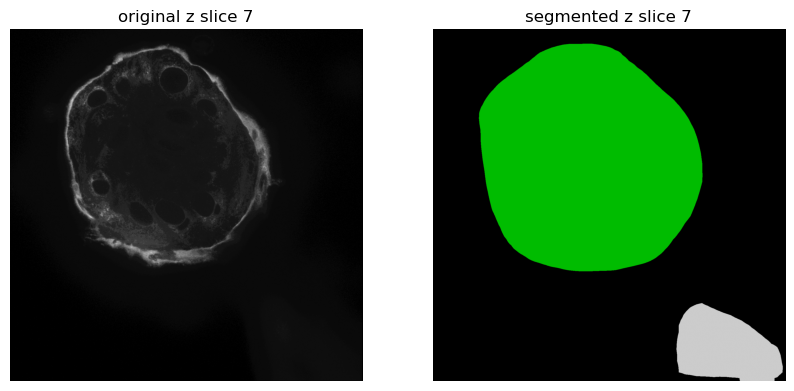

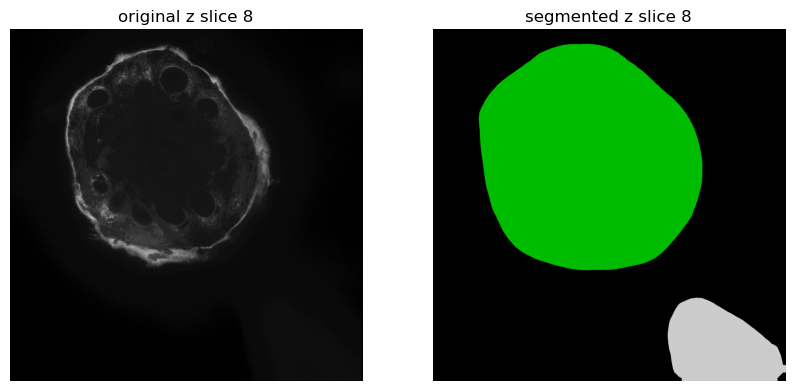

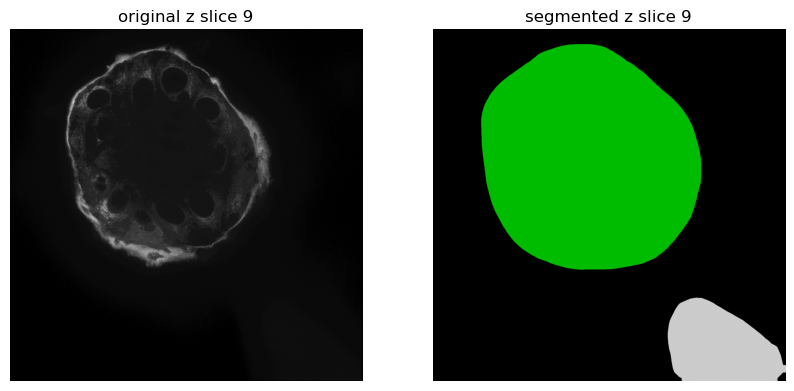

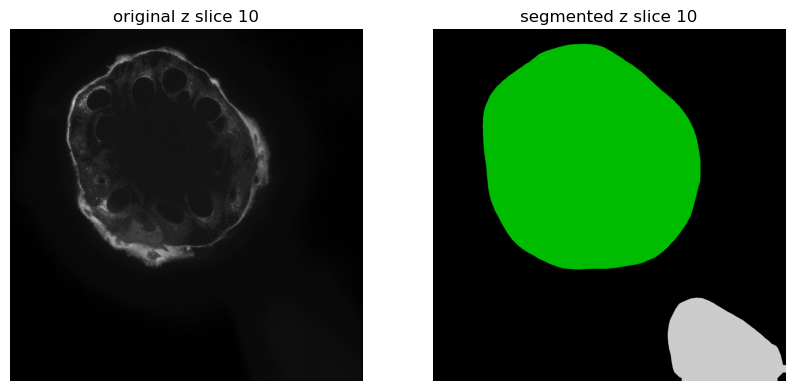

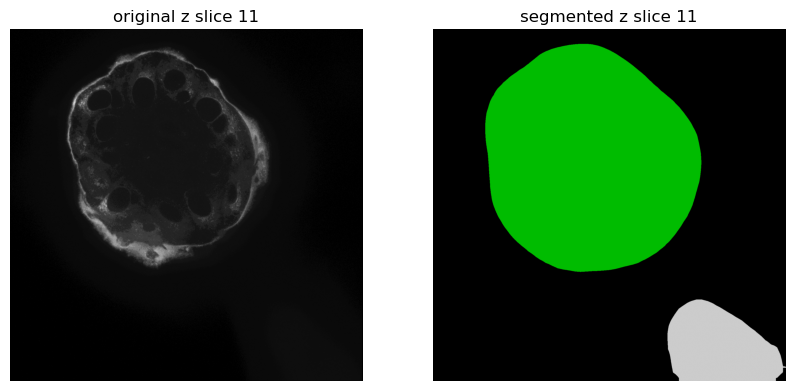

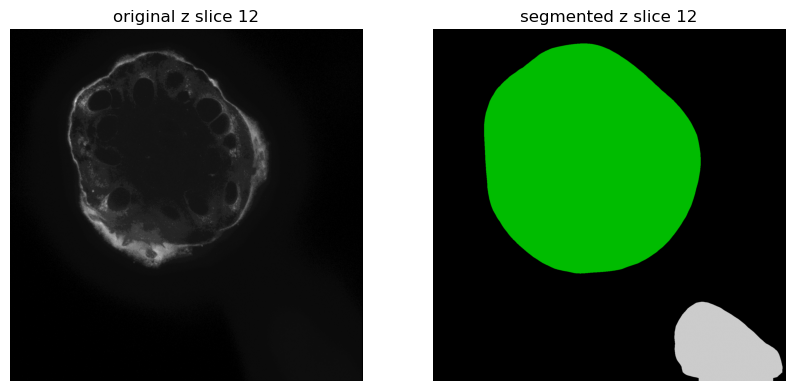

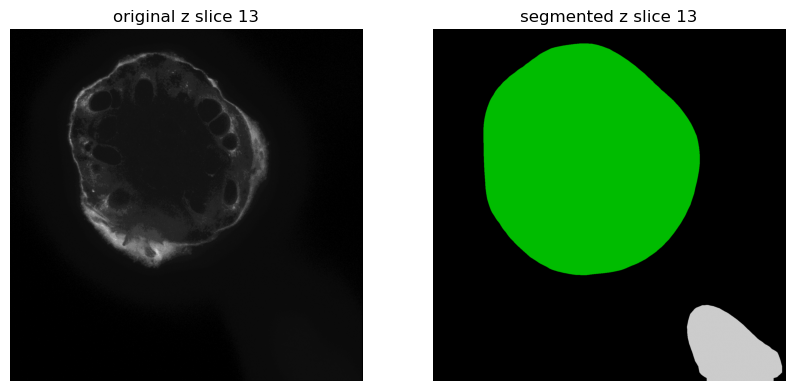

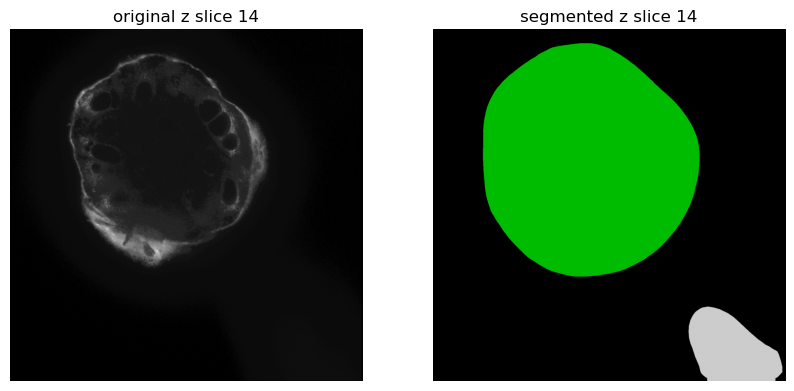

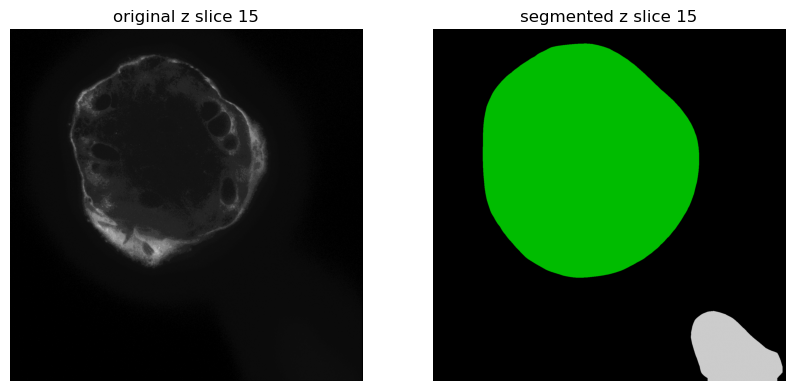

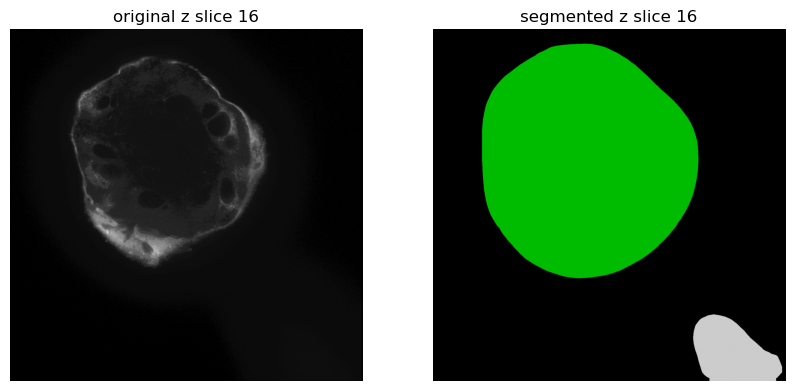

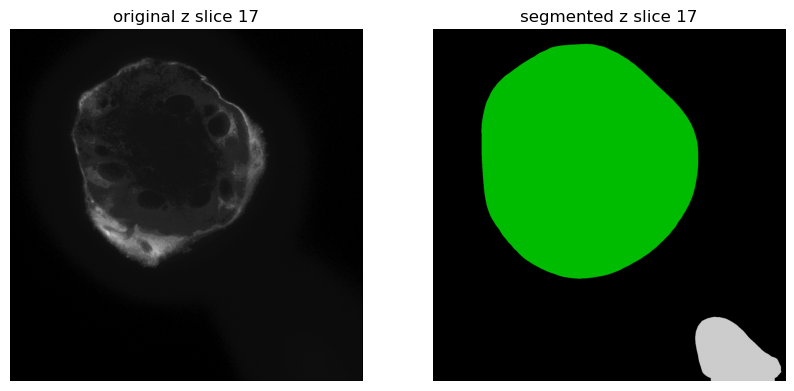

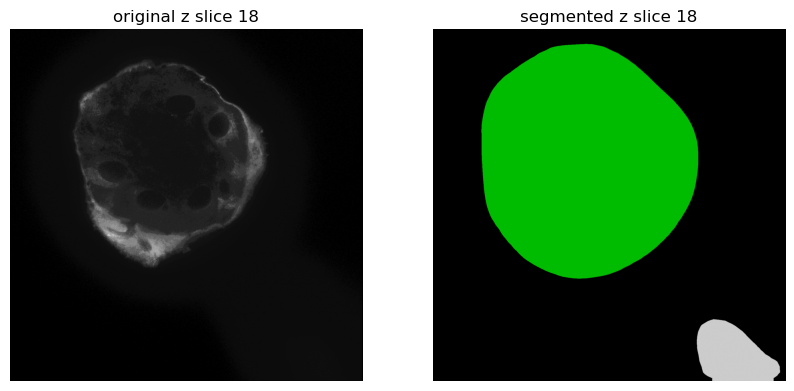

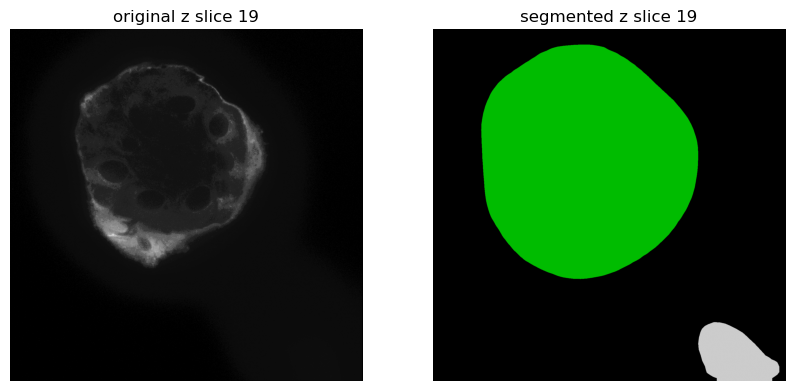

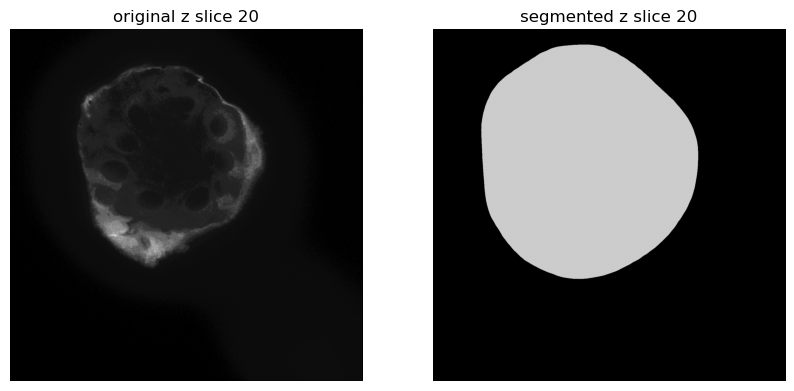

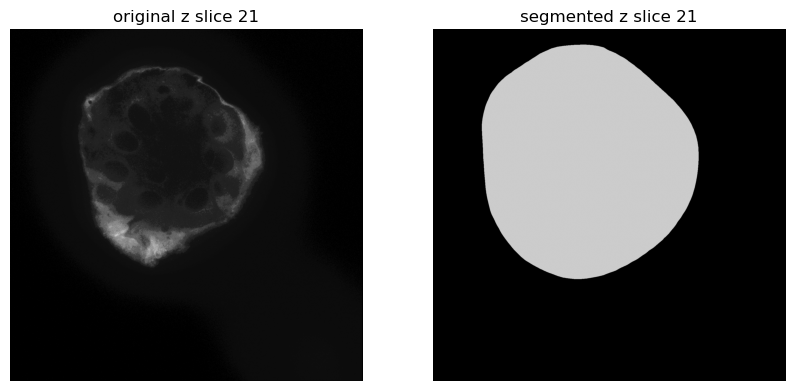

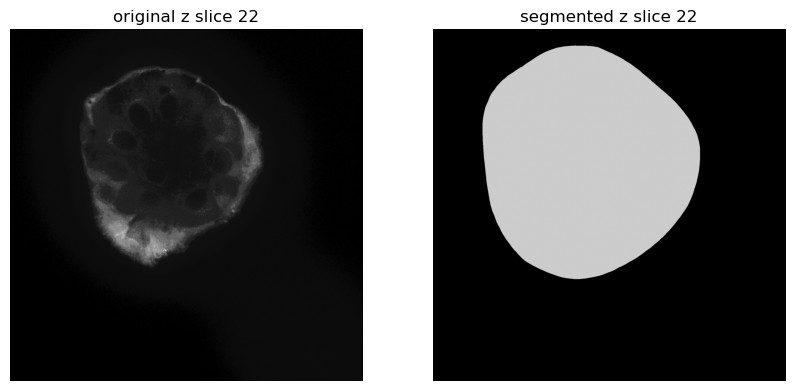

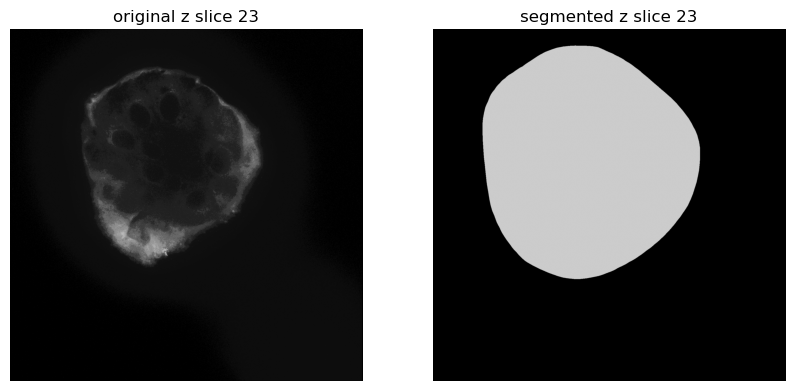

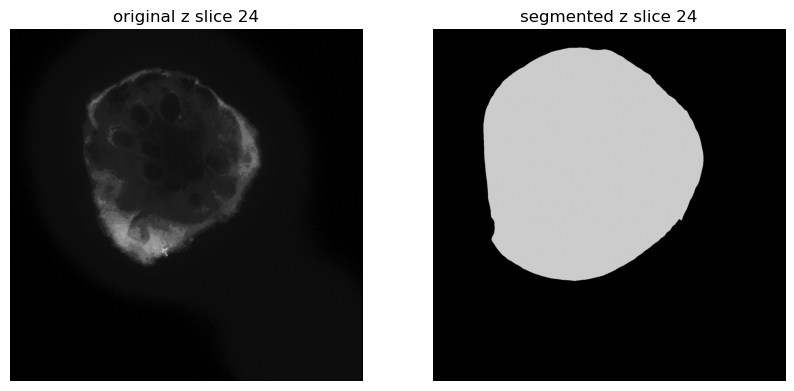

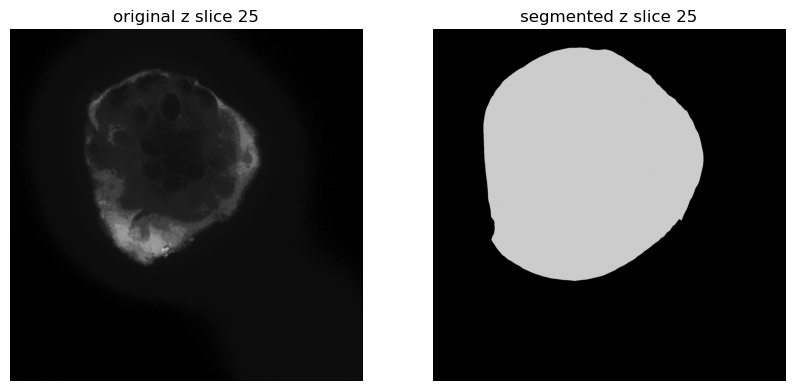

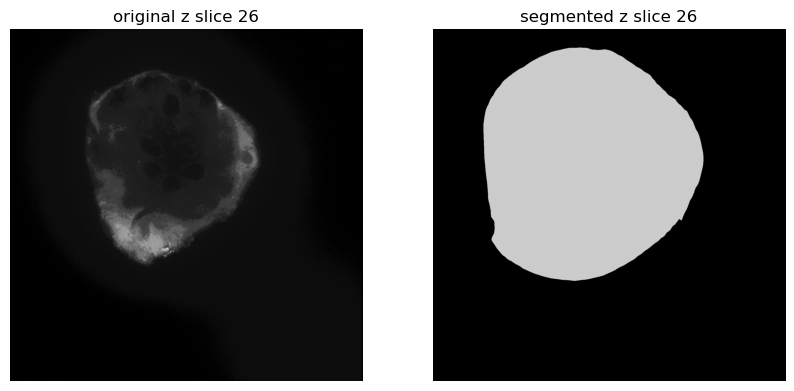

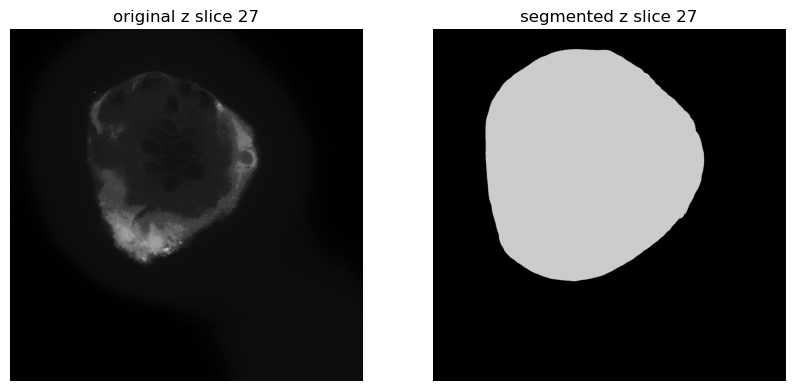

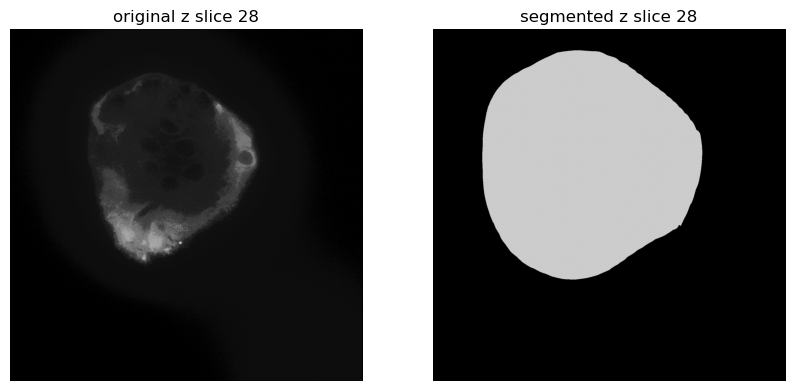

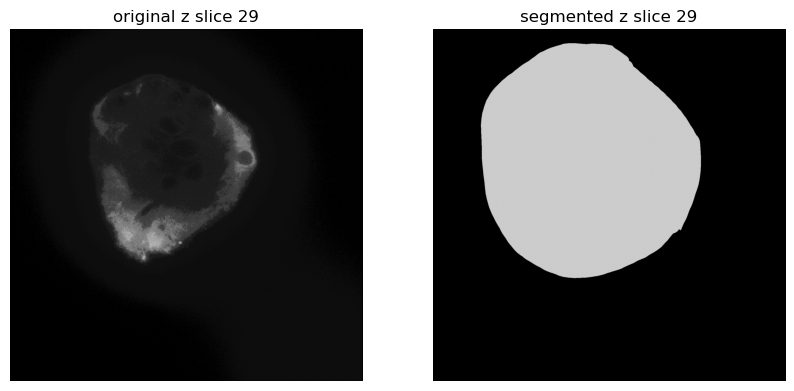

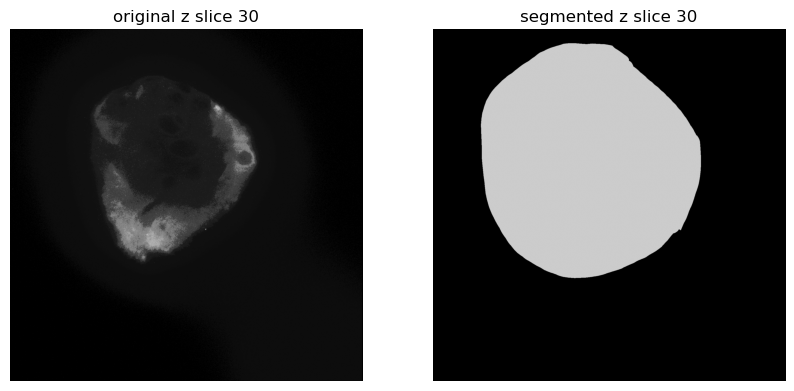

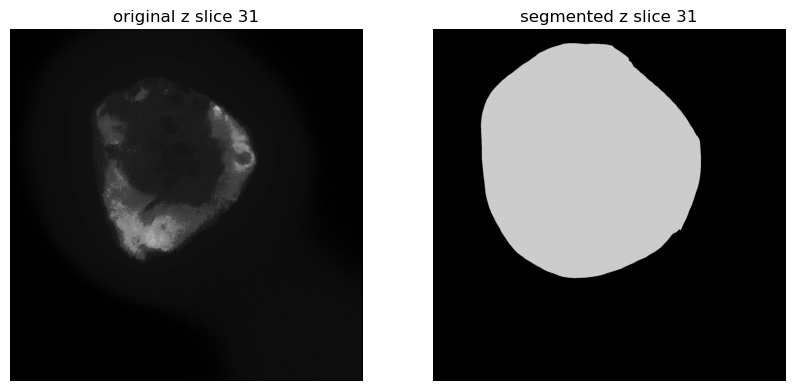

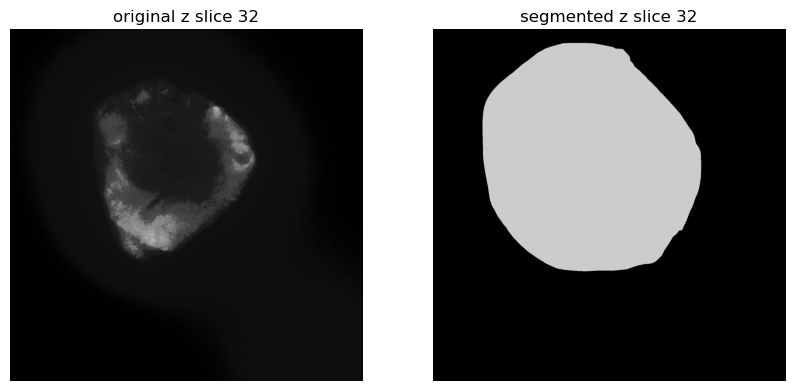

In [96]:
for zslice in range(masks.shape[0]):
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(original_imgs[zslice], cmap="gray")
    plt.title(f"original z slice {zslice}")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(masks[zslice], cmap="nipy_spectral")
    plt.title(f"segmented z slice {zslice}")
    plt.axis("off")
    plt.show()

# Extra

In [ ]:
decoupling = DecoupleAndReconstructMasks(reconstruction_dict[3], visualize=False)
mask = decoupling.run_reconstruction()
plt.imshow(mask)

In [ ]:
decoupling.unique_masks_df
decoupling.output_df

In [ ]:
decoupled_masks = {
    "z_slice": [],
    "mask": [],
}
for zslice in tqdm.tqdm(range(len(reconstruction_dict))):
    decoupling = DecoupleAndReconstructMasks(
        reconstruction_dict[zslice], visualize=False
    )
    mask = decoupling.run_reconstruction()
    decoupled_masks["z_slice"].append(zslice)
    decoupled_masks["mask"].append(mask)

# conver the masks to a numpy array
masks = np.array(decoupled_masks["mask"])

In [ ]:
decoupling.output_df

In [ ]:
# save the masks to a tiff file
tifffile.imwrite(mask_file_path, masks)

In [ ]:
if in_notebook:
    for i in range(masks.shape[0]):
        plt.figure(figsize=(7, 7))
        plt.subplot(1, 2, 1)
        plt.imshow(original_imgs[i])
        plt.title(f"Original Image {i}")
        plt.subplot(1, 2, 2)
        plt.imshow(masks[i])
        plt.title(f"Reconstructed Mask {i}")
        plt.show()

# Graveyard


In [ ]:
# class DecoupleAndReconstructMasks:
#     """
#     This class is used to decouple and reconstruct masks from a stack of segmented masks
#     1. Extract unique masks from a stack of segmented masks
#     2. Decouple masks based on xy coordinates
#     3. Reconstruct masks based on xy coordinates

#     """

#     def __init__(self, reconstruction_dict_partial: dict, visualize: bool = False):
#         """
#         Initialize the DecoupleAndReconstructMasks class

#         Parameters
#         ----------
#         reconstruction_dict_partial : dict
#             Partial reconstruction dict that contains mask identities of a stack of segmented masks
#             from a sliding window decomposition
#         visualize : bool, optional
#             Whether to visualize the reconstructed masks
#         """
#         self.image_stack = reconstruction_dict_partial
#         self.visualize = visualize

#     def extract_unique_masks(self):
#         mask_indices_dict = {
#             "unique_mask": [],
#             "mask_indices": [],
#             "psuedo_slice": [],
#             "y_x_coords": [],
#             "bbox": [],
#         }
#         # find each unqiue mask identity via pixel value
#         unique_masks = np.unique(self.image_stack)
#         # loop through each unique mask identity
#         # drop the backgound as a mask identity
#         unique_masks = unique_masks[unique_masks != 0]
#         for unique_mask in unique_masks:
#             # loop through each mask image
#             for psuedo_slice in range(len(self.image_stack)):
#                 # find where the unique mask identity is in the mask image
#                 tmp_image = self.image_stack[psuedo_slice]
#                 # get only the unique mask
#                 image_for_coordinates = np.array(
#                     tmp_image == unique_mask, dtype=np.uint8
#                 )
#                 mask_indices = np.where(tmp_image == unique_mask)
#                 # if the mask identity is in the mask image
#                 mask_indices_dict["unique_mask"].append(unique_mask)
#                 mask_indices_dict["mask_indices"].append(mask_indices)
#                 mask_indices_dict["psuedo_slice"].append(psuedo_slice)
#                 c = skimage.measure.regionprops(image_for_coordinates)
#                 for property in c:
#                     centroid = property.centroid
#                     bbox = property.bbox
#                     mask_indices_dict["y_x_coords"].append(centroid)
#                     mask_indices_dict["bbox"].append(bbox)
#                 if len(mask_indices_dict["y_x_coords"]) < len(
#                     mask_indices_dict["mask_indices"]
#                 ):
#                     mask_indices_dict["y_x_coords"].append(None)
#                     mask_indices_dict["bbox"].append(None)
#         self.unique_masks_df = pd.DataFrame(mask_indices_dict)

#     def decouple_masks(self):
#         # group each index into a dict of dicts based on if the xy coordinates are within a certain distance of each other
#         # and if the x_y coordinates are within the bbox of the other coordinates
#         output_dict = {
#             "group_index": [],
#             "df_indices": [],
#             "index_comparison": [],
#             "mask_indices": [],
#             "psuedo_slice": [],
#             "y_x_coords": [],
#             "bbox": [],
#             "area": [],
#         }
#         if self.unique_masks_df["psuedo_slice"].nunique() > 2:
#             for i in range(len(self.unique_masks_df)):

#                 # get the x_y coordinates and bbox of the current index
#                 current_xy = self.unique_masks_df["y_x_coords"][i]
#                 current_bbox = self.unique_masks_df["bbox"][i]
#                 # if the x_y coordinates are not None
#                 if current_xy is not None:
#                     # loop through the rest of the indices
#                     for j in range(len(self.unique_masks_df)):
#                         if i != j:
#                             if f"{i},{j}" not in output_dict["index_comparison"]:
#                                 if f"{j},{i}" not in output_dict["index_comparison"]:
#                                     # get the x_y coordinates and bbox of the other index
#                                     other_xy = self.unique_masks_df["y_x_coords"][j]
#                                     other_bbox = self.unique_masks_df["bbox"][j]
#                                     # if the x_y coordinates are not None
#                                     if other_xy is not None:
#                                         distance = euclidian_2D_distance(
#                                             current_xy, other_xy
#                                         )
#                                         if distance < distance_threshold:
#                                             # check which bounding box has the larger area
#                                             if (
#                                                 get_larger_bbox(
#                                                     current_bbox, other_bbox
#                                                 )
#                                                 == current_bbox
#                                             ):
#                                                 coordinate_inside_box = (
#                                                     check_coordinate_inside_box(
#                                                         other_xy, current_bbox
#                                                     )
#                                                 )
#                                                 if coordinate_inside_box:
#                                                     output_dict["df_indices"].append(i)
#                                                     output_dict["mask_indices"].append(
#                                                         self.unique_masks_df[
#                                                             "mask_indices"
#                                                         ][i]
#                                                     )
#                                             elif (
#                                                 get_larger_bbox(
#                                                     current_bbox, other_bbox
#                                                 )
#                                                 == other_bbox
#                                             ):
#                                                 coordinate_inside_box = (
#                                                     check_coordinate_inside_box(
#                                                         current_xy, other_bbox
#                                                     )
#                                                 )
#                                                 if coordinate_inside_box:
#                                                     output_dict["df_indices"].append(j)
#                                                     output_dict["mask_indices"].append(
#                                                         self.unique_masks_df[
#                                                             "mask_indices"
#                                                         ][j]
#                                                     )
#                                             else:
#                                                 coordinate_inside_box = False
#                                             # check if the x_y coordinates are within the bbox of the other coordinates
#                                             if coordinate_inside_box:
#                                                 # add the indices to the output dict
#                                                 output_dict["group_index"].append(i)
#                                                 output_dict["psuedo_slice"].append(
#                                                     self.unique_masks_df[
#                                                         "psuedo_slice"
#                                                     ][i]
#                                                 )
#                                                 output_dict["y_x_coords"].append(
#                                                     other_xy
#                                                 )
#                                                 output_dict["bbox"].append(other_bbox)
#                                                 mask_array = self.unique_masks_df[
#                                                     "mask_indices"
#                                                 ][j]
#                                                 # get the area of the mask
#                                                 mask_array = np.array(mask_array)
#                                                 area = (
#                                                     mask_array.shape[0]
#                                                     * mask_array.shape[1]
#                                                 )
#                                                 output_dict["area"].append(area)
#                                                 output_dict["index_comparison"].append(
#                                                     f"{i},{j}"
#                                                 )
#         # for the first and last slice where there will be stacking and consensus is not needed
#         else:
#             for i in range(len(self.unique_masks_df)):
#                 output_dict["group_index"].append(i)
#                 output_dict["df_indices"].append(i)
#                 output_dict["mask_indices"].append(
#                     self.unique_masks_df["mask_indices"][i]
#                 )
#                 output_dict["psuedo_slice"].append(
#                     self.unique_masks_df["psuedo_slice"][i]
#                 )
#                 output_dict["y_x_coords"].append(self.unique_masks_df["y_x_coords"][i])
#                 output_dict["bbox"].append(self.unique_masks_df["bbox"][i])
#                 output_dict["index_comparison"].append(f"{i},{i}")
#                 mask_array = self.unique_masks_df["mask_indices"][i]
#                 # get the area of the mask
#                 mask_array = np.array(mask_array)
#                 area = mask_array.shape[0] * mask_array.shape[1]
#                 output_dict["area"].append(area)

#         self.output_df = pd.DataFrame(output_dict)

#     def reconstruct_masks(self):
#         dict_of_masks = {}
#         # get all unique group indices
#         group_indices = np.unique(self.output_df["group_index"])
#         for index in group_indices:
#             df = self.output_df.loc[self.output_df["group_index"] == index]
#             if len(df) > 0:
#                 # keep the row with the largest area
#                 largest_area_index = df["area"].idxmax()
#                 largest_area_row = df.loc[largest_area_index]
#                 consensus_mask = largest_area_row["mask_indices"]

#                 dict_of_masks[index] = consensus_mask

#         # get the dimensions of the original image
#         self.reassembled_masks = np.zeros(
#             (original_imgs.shape[1], original_imgs.shape[2]), dtype=np.uint8
#         )
#         # loop through each mask in the dict
#         if len(dict_of_masks) <= 2:
#             self.reassembled_masks[dict_of_masks[index]] = 1
#         else:
#             for index, mask in dict_of_masks.items():
#                 # set the pixels in the reassembled masks to the index value
#                 self.reassembled_masks[mask] = index

#     def visualize_reconstructed_masks(self):
#         # visualize the reassembled masks
#         plt.figure(figsize=(5, 5))
#         plt.imshow(self.reassembled_masks)
#         plt.show()

#     def run_reconstruction(self):
#         self.extract_unique_masks()
#         self.decouple_masks()
#         self.reconstruct_masks()

#         if self.visualize:
#             self.visualize_reconstructed_masks()
#         return self.reassembled_masks